In [ ]:
"""
Loading frameworks
"""

import cv2
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np


In [ ]:
"""
Importing test image and initializing the data
"""

straight_lines_image = cv2.imread('./test_images/straight_lines1.jpg')
image_size = (straight_lines_image.shape[1], straight_lines_image.shape[0])

print('Image size = {}'.format(image_size))


In [ ]:
"""
Useful functions
"""

def show_image(image, cmap=None):
    """
    Displays an image
    """
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def read_image(image_name):
    image = cv2.imread(image_name)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

In [ ]:
"""
Camera calibration
"""

def draw_chessboard_corners(image, corners, pattern_size, ret):
    """
    Draws chessboard corners over the image and displays a result
    """
    image = cv2.drawChessboardCorners(image, pattern_size, corners, ret)
    show_image(image)

def calibrate_camera(image_names, pattern_size=(9, 6), show_corners=False):
    """
    Calibrates the camera based on images set with chessboards patterns provided.
    Returns camera calibration matrix and distortion coefficients
    """
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
    
    image_size = None
    
    for image_name in image_names:
        image = cv2.imread(image_name)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if image_size is None:
            image_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            if show_corners:
                draw_chessboard_corners(image, corners, pattern_size, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

def undistort_image(image, mtx, dist):
    """
    Undistorts an image based on camera calibration matrix and distortion coefficients
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

def show_undistorted_images(image_names, mtx, dist):
    """
    Displays undistorted versions of input images
    """
    for image_name in image_names:
        image = cv2.imread(image_name)
        image = undistort_image(image, mtx, dist)
        show_image(image)
            

In [ ]:
"""
Loading camera calibration images and calculating calibration matrix and distortion coefficients
"""

calibration_images = glob.glob('./camera_cal/calibration*.jpg')
calibration_mtx, calibration_dist = calibrate_camera(calibration_images, pattern_size=(9, 6), show_corners=False)


In [ ]:
"""
Sobel gradients
"""

def apply_sobel_thresh(gray, orient='x', thresh=(0, 255), kernel_size=3):
    """
    Applies a Sobel threshold with given orientation x or y
    """
    if orient == 'x':
        orient_num = (1, 0)
    elif orient == 'y':
        orient_num = (0, 1)

    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient_num[0], orient_num[1], ksize=kernel_size))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def apply_direction_sobel(gray, kernel_size=15, thresh=(0.7, 1.3)):
    """
    Applies a direction Sobel threshold
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(abs_grad)
    binary_output[(abs_grad >= thresh[0]) & (abs_grad <= thresh[1])] = 1
    return binary_output

def apply_magnitude_sobel(gray, kernel_size=3, thresh=(10, 60)):
    """
    Applies a magnitude Sobel threshold
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def blur_image(image, kernel_size=7):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def thresh_gray_image(gray, thresh=(140, 255)):
    ret, gray = cv2.threshold(gray, thresh[0], thresh[1], cv2.THRESH_TOZERO)
    return gray

def combine_magnitude_and_direction(gray, mag_thresh=(10, 60), dir_thresh=(0.7, 1.3)):
    mag_binary = apply_magnitude_sobel(gray, thresh=mag_thresh)
    dir_binary = apply_direction_sobel(gray, thresh=dir_thresh)
    binary_output = np.zeros_like(mag_binary)
    binary_output[(mag_binary == 1) & (dir_binary == 1)] = 1
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_mask(image):
    left_bottom = [120, 720]
    right_bottom = [1160, 720]
    # left_apex = [460, 500]
    # right_apex = [820, 500]
    
    left_apex = [460, 470]
    right_apex = [820, 470]
    vertices = np.array([[left_bottom, left_apex, right_apex, right_bottom]], dtype=np.int32) #right_subapex, left_subapex, left_subbottom
                         
    return region_of_interest(image, vertices)

In [ ]:

image = read_image('./test_images/challenge1.jpg')
show_image(image)

s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
show_image(s_channel,cmap='gray')
gray = thresh_gray_image(s_channel, thresh=(95, 255))
gray = combine_magnitude_and_direction(gray, mag_thresh=(10, 150), dir_thresh=(0.9, 1.1))
show_image(gray, cmap='gray')

blurred = blur_image(image)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(gray, cmap='gray')
gray = thresh_gray_image(gray, thresh=(140, 255))
print(cv2.sumElems(gray))
#gray = thresh_gray_image(gray, thresh=(40, 255))

img = apply_magnitude_sobel(gray, kernel_size=3, thresh=(10, 60))
show_image(img, cmap='gray')

In [ ]:
"""
Color thresholding
"""
def apply_hls_thresh(image, thresh=(70, 255)):
    """
    Applies a threshold for Saturation layer of image in HLS color space
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


In [ ]:

def combine_sobel_and_hls(image):
    blurred = blur_image(image)
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    threshed = thresh_gray_image(gray)
    sobel_binary = combine_magnitude_and_direction(threshed)
    masked = apply_mask(sobel_binary)
    
    sumElems = cv2.sumElems(masked)[0]
    if sumElems < 1000:
        threshed = thresh_gray_image(gray, thresh=(30, 255))
        sobel_binary = combine_magnitude_and_direction(threshed, mag_thresh=(10, 50), dir_thresh=(0.8, 1.2))
        masked = apply_mask(sobel_binary)
    
    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    s_threshed = thresh_gray_image(s_channel, thresh=(95, 255))
    hls_binary = combine_magnitude_and_direction(s_threshed, mag_thresh=(10, 150), dir_thresh=(0.9, 1.1))
    s_masked = apply_mask(hls_binary)
       
    binary_output = np.zeros_like(sobel_binary)
    binary_output[(masked == 1) | (s_masked == 1)] = 1
    return binary_output


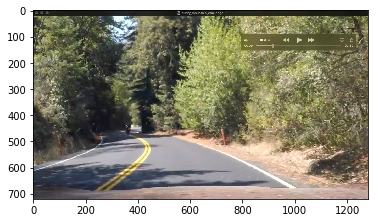

s channel


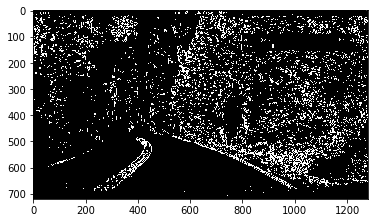

blue channel


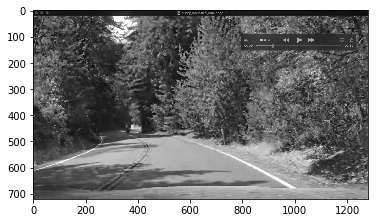

sobeled


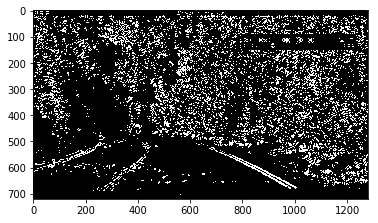

threshed


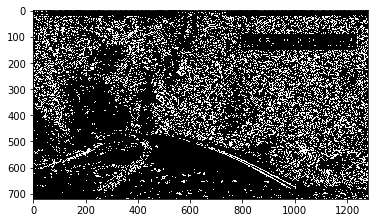

all combined


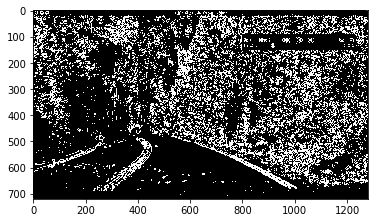

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 0],
       ..., 
       [0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [344]:


def test_func(image, show_plot=False):
    if show_plot:
        show_image(image)
    # image = blur_image(image, kernel_size=9)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    
    thresh = [150, 255]
    #s_binary_output = np.zeros_like(s_channel)
    #s_binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    #s_threshed = thresh_gray_image(s_channel, thresh=(95, 255))
    s_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(20, 100), kernel_size=25)
    #sx_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(10, 100), kernel_size=21)
    #sy_binary_output = apply_sobel_thresh(s_channel, orient='y', thresh=(10, 100), kernel_size=21)
    #sx_binary_output = apply_magnitude_sobel(s_channel,thresh=(15, 100), kernel_size=3)
    #sd_binary_output = apply_direction_sobel(s_channel, thresh=(0.8, 1.2), kernel_size=25)
    #s_binary_output = np.zeros_like(sx_binary_output) 
    #s_binary_output[(sx_binary_output == 1) & (sy_binary_output == 1) & (sd_binary_output == 1)] = 1
    if show_plot:
        print('s channel')
        show_image(s_binary_output, cmap='gray')
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if show_plot:
        print('gray channe;')
        show_image(gray, cmap='gray')
    threshed_m = apply_magnitude_sobel(gray, kernel_size=3, thresh=(20, 100))
    # show_image(threshed_m, cmap='gray')
    threshed_d = apply_direction_sobel(gray, kernel_size=15, thresh=(0.8, 1.2))
    # show_image(threshed_d, cmap='gray')
    
    sobelx = apply_sobel_thresh(gray, orient='x', thresh=(20, 100), kernel_size=7)
    if show_plot:
        print('sobeled x')
        show_image(sobelx, cmap='gray')
    threshed = np.zeros_like(threshed_m)
    threshed[((threshed_m == 1) & (threshed_d == 1)) & (sobelx == 1)] = 1
    if show_plot:
        print('threshed all')
        show_image(threshed, cmap='gray')
    
    thresh = [135, 255]
    l_binary_output = np.zeros_like(l_channel)
    l_binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    if show_plot:
        print('L channel')
        show_image(l_binary_output, cmap='gray')

    s_l = np.zeros_like(l_binary_output)
    # s_l[((threshed == 1) & (l_binary_output == 1)) | (s_binary_output == 1)] = 1
    # s_l[(sobelx == 1) | (s_binary_output == 1)] = 1
    
    s_l[((sobelx == 1) & (l_binary_output == 1)) | (s_binary_output == 1)] = 1
    if show_plot:
        print('all combined')
        show_image(s_l, cmap='gray')
        
    return s_l

def test_func3(image, show_plot=False):
    if show_plot:
        show_image(image)
    # image = blur_image(image, kernel_size=9)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    
    thresh = [150, 255]
    #s_binary_output = np.zeros_like(s_channel)
    #s_binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    #s_threshed = thresh_gray_image(s_channel, thresh=(95, 255))
    s_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(20, 100), kernel_size=5)
    #sx_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(10, 100), kernel_size=21)
    #sy_binary_output = apply_sobel_thresh(s_channel, orient='y', thresh=(10, 100), kernel_size=21)
    #sx_binary_output = apply_magnitude_sobel(s_channel,thresh=(15, 100), kernel_size=3)
    #sd_binary_output = apply_direction_sobel(s_channel, thresh=(0.8, 1.2), kernel_size=25)
    #s_binary_output = np.zeros_like(sx_binary_output) 
    #s_binary_output[(sx_binary_output == 1) & (sy_binary_output == 1) & (sd_binary_output == 1)] = 1
    
    if show_plot:
        print('s channel')
        show_image(s_binary_output, cmap='gray')
    
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = image[:, :, 2] # blue channel
    if show_plot:
        print('blue channel')
        show_image(gray, cmap='gray')
        
    threshed_m = apply_magnitude_sobel(gray, kernel_size=3, thresh=(10, 100))
    #show_image(threshed_m, cmap='gray')
    threshed_d = apply_direction_sobel(gray, kernel_size=21, thresh=(0.7, 1.3))
    #show_image(threshed_d, cmap='gray')
    
    sobelx = apply_sobel_thresh(gray, orient='x', thresh=(20, 100), kernel_size=25)
    sobely = apply_sobel_thresh(gray, orient='y', thresh=(20, 100), kernel_size=25)
    sobel_comb = np.zeros_like(sobelx)
    sobel_comb[(sobelx == 1) & (sobely == 1)] = 1
    
    if show_plot:
        print('sobeled')
        show_image(sobel_comb, cmap='gray')
    threshed = np.zeros_like(threshed_m)
    threshed[((threshed_m == 1) & (threshed_d == 1))] = 1
    if show_plot:
        print('threshed')
        show_image(threshed, cmap='gray')
    

    s_l = np.zeros_like(threshed)
    
    s_l[(sobel_comb == 1) | (s_binary_output == 1)] = 1
    if show_plot:
        print('all combined')
        show_image(s_l, cmap='gray')
        
    return s_l

def test_func2(image, show_plot=False):
    #hls = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
    hls = image
    l_channel = hls[:, :, 0]
    u_channel = hls[:, :, 1]
    v_channel = hls[:, :, 2]
    show_image(l_channel, cmap='gray')
    print()
    show_image(u_channel, cmap='gray')
    show_image(v_channel, cmap='gray')

image = read_image('./test_images/hard3.jpg')
test_func3(image, show_plot=True)


In [ ]:
"""
Perspective transformation
"""

def get_perspective_transform(src, dst):
    """
    Calculates a matrix of perspective transformation from src to dst points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(image, M, image_size):
    """
    Returns a warped image after applying a perspective transformation
    """
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)


In [ ]:
"""
Calculate a perspective matrix
"""

image = read_image('./test_images/straight_lines2.jpg')
# src = np.float32([[589, 454], [695, 454], [1048, 682], [275, 682]])
# dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

# src = np.float32([[558, 476], [730, 476], [1048, 682], [275, 682]])

# src = np.float32([[460, 546], [836, 546], [1048, 682], [275, 682]])
# dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

src = np.float32([[568, 470], [721, 470], [1048, 682], [275, 682]])
dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

# src = np.float32([[525, 500], [767, 500], [1048, 682], [275, 682]])
# dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

perspective_M = get_perspective_transform(src, dst)
perspective_Minv = get_perspective_transform(dst, src)

def test_perspective(image, M, image_size):
    image = warp_perspective(image, M, image_size)
    show_image(image)

test_perspective(image, perspective_M, image_size)
    

In [ ]:

image = read_image('./test_images/straight_lines2.jpg')
# warped = combine_magnitude_and_dir(image)
warped = combine_sobel_and_hls(image)
show_image(warped, cmap='gray')

warped = warp_perspective(warped, perspective_M, image_size)
show_image(warped, cmap='gray')

In [349]:

def sliding_window_search(binary_warped, show_plot=False):
    
    histogram = np.sum(binary_warped[3 * binary_warped.shape[0] // 4:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = 200 + np.argmax(histogram[200:(midpoint-220)])
    rightx_base = np.argmax(histogram[(midpoint+220):-200]) + midpoint + 220
    
    lmax = np.amax(histogram[:(midpoint)])
    rmax = np.amax(histogram[(midpoint):])
    
    '''
    if lmax < 50 or rmax < 50:
        histogram = np.sum(binary_warped[:,:], axis=0)
        if lmax < 50:
            leftx_base = np.argmax(histogram[:midpoint])
        if rmax < 50:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        """
        window_width = 50 
        window = np.ones(window_width) # Create our window template that we will use for convolutions
    
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        if lmax < 50:
            l_sum = np.sum(warped[int(0*binary_warped.shape[0]/4):,:int(binary_warped.shape[1]/2)], axis=0)
            #leftx_base = int(np.argmax(np.convolve(window,l_sum))-window_width/2)
            leftx_base = int(np.argmax(np.convolve(window,l_sum))-window_width/2)
        if rmax < 50:
            r_sum = np.sum(warped[int(0*binary_warped.shape[0]/4):,int(binary_warped.shape[1]/2):], axis=0)
            rightx_base = int(np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2))
        """
    '''
    if show_plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Choose the number of sliding windows
    nwindows = 150
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    unfound_left_count = 0
    unfound_right_count = 0
    stop_left = False
    stop_right = False
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if show_plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        if stop_left == False:
            left_lane_inds.append(good_left_inds)
        if stop_right == False:
            right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        if len(good_left_inds) < 10:
            unfound_left_count += 1
        else:
            unfound_left_count = 0
        if len(good_right_inds) < 10:
            unfound_right_count += 1
        else:
            unfound_right_count = 0
        
        if unfound_left_count > 3: # and win_xleft_low <= 0:
            stop_left = True
        if unfound_right_count > 3: # and win_xright_high >= (binary_warped.shape[1] - 1):
            stop_right = True

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(lefty) > 0 and len(leftx) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None

    if show_plot and left_fit is not None and right_fit is not None:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
            
            
    if left_fit is not None and right_fit is not None:
        if (left_fit[0] * right_fit[0]) < 0 or left_fit[2] >= right_fit[2]:
            left_fit = None
            right_fit = None
                
    return left_fit, right_fit
    

def search_points_knowing_polys(binary_warped, left_fit, right_fit, show_plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(lefty) > 0 and len(leftx) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
        
    last_y = (binary_warped.shape[0] - 1)
    if left_fit is not None:
        first_left_x = left_fit[2]
        last_left_x = left_fit[0] * last_y**2 + left_fit[1] * last_y + left_fit[2]
        if first_left_x > (3*binary_warped.shape[1]//4) or last_left_x < 130:
            left_fit = None
    if right_fit is not None:
        first_right_x = right_fit[2]
        last_right_x = right_fit[0] * last_y**2 + right_fit[1] * last_y + right_fit[2]
        if first_right_x < (binary_warped.shape[1]//4) or last_right_x > 1150:
            right_fit = None
    
    if show_plot and left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return left_fit, right_fit
    
def sliding_window_search2(warped):
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions
    
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(2*warped.shape[0]/2):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(2*warped.shape[0]/2):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
    
        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found %%!
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    

In [ ]:

def draw_lines(image, warped, image_size, Minv, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (image_size[0], image_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    return result


In [324]:

def full_process_image(image, image_size, mtx, dist, M, Minv, show_plot=False):
    undistorted = undistort_image(image, mtx, dist)
    threshed = test_func3(undistorted, show_plot=show_plot)
    #threshed = combine_sobel_and_hls(undistorted)
    #masked = apply_mask(threshed)
    if show_plot:
        show_image(threshed, cmap='gray')
    warped = warp_perspective(threshed, M, image_size)
    if show_plot:
        show_image(warped, cmap='gray')
    left_fit, right_fit = sliding_window_search(warped, show_plot)
    # sliding_window_search2(warped)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    image_width = warped.shape[1]
    left_fitx[(left_fitx < 0)] = 0
    left_fitx[(left_fitx >= image_width)] = image_width - 1
    right_fitx[right_fitx < 0] = 0
    right_fitx[right_fitx >= image_width] = image_width - 1
    res = draw_lines(undistorted, warped, image_size, Minv, left_fitx, right_fitx, ploty)
    return res
    
def process_image(image):
    return full_process_image(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv)


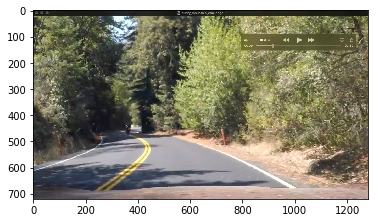

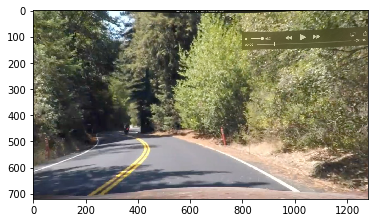

s channel


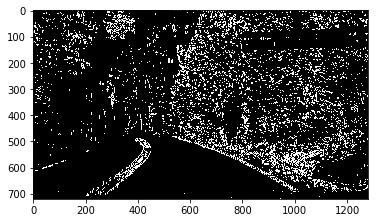

blue channel


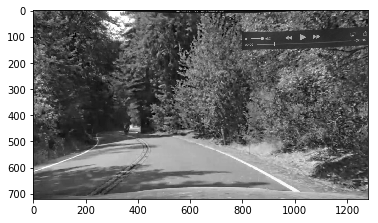

sobeled


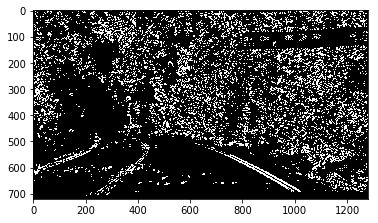

threshed


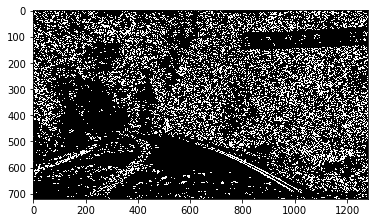

all combined


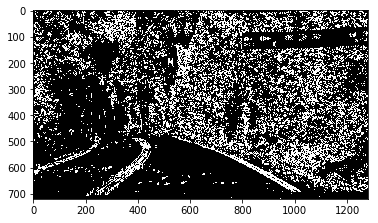

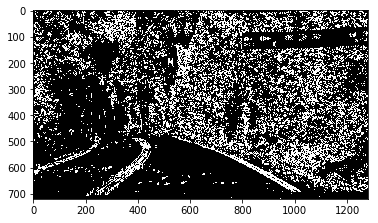

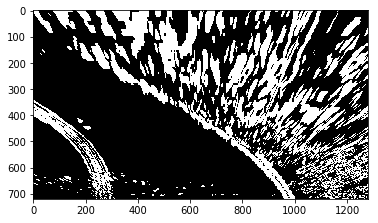

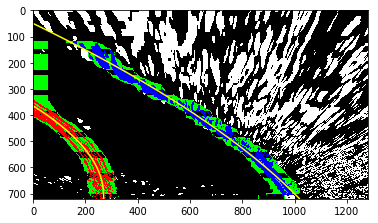

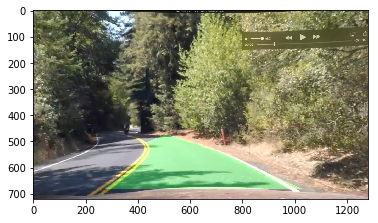

In [350]:

image = read_image('./test_images/hard3.jpg')
show_image(image)
show_image(full_process_image(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv, show_plot=True))


In [ ]:

class Lane():
    def __init__(self, n, image_size=(1280, 720), lane_type='r'):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = None
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = None
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        self.n = n
        self.image_size = image_size
        self.lane_type = lane_type
        
        self.iterations = 0
        
    def append_x(self, new_x, new_y):
        self.allx = new_x[:]
        self.ally = new_y[:]
        self.iterations += 1
        
        need_append = True
        self.current_fit = np.polyfit(new_y, new_x, 2)
        
        """
        if current_fit is not None:
            current_fitx = current_fit[0] * new_y**2 + current_fit[1] * new_y + current_fit[2]
            count = len(current_fitx)
            high_min = np.amin(current_fitx[:count // 3])
            center_min = np.amin(current_fitx[count // 3: 2 * count //3])
            low_min = np.amin(current_fitx[2 * count // 3:])
            high_max = np.amax(current_fitx[:count // 3])
            center_max = np.amax(current_fitx[count // 3: 2 * count //3])
            low_max = np.amax(current_fitx[2 * count // 3:])
            
            #print(high_min - center_max + low_min - center_max)
            #print(high_max - center_min + low_max - center_min)
            
        
        if self.best_fit is not None and current_fit is not None:
            old_fit = self.best_fit
            old_fitx = old_fit[0] * new_y**2 + old_fit[1] * new_y + old_fit[2]
            current_fitx = current_fit[0] * new_y**2 + current_fit[1] * new_y + current_fit[2]
                
            dist = np.sum(np.absolute(np.subtract(current_fitx, old_fitx)))
            if dist > 20000:
                self.current_fit = current_fit
                need_append = True
            
#            print('Distance fitx is {}'.format(dist))
        else:
            self.current_fit = current_fit
        """
            
        if self.iterations > self.n:
            self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
            
        if self.recent_xfitted is None or self.recent_xfitted.shape[0] == 0:
            self.recent_xfitted = np.vstack([new_x])
        elif need_append == True:
            self.recent_xfitted = np.vstack([self.recent_xfitted, new_x])
        
        count = self.recent_xfitted.shape[0]
        self.bestx = np.average(self.recent_xfitted, axis=0, weights=np.linspace(1, 6, count))
        
        if len(self.bestx) > 0:
            self.best_fit = np.polyfit(self.ally, self.bestx, 2)
            
        if self.best_fit is None:
            self.detected = False
        else:
            self.detected = True
        

In [339]:
left_lane = None
right_lane = None
def init_lanes():
    global left_lane
    left_lane = Lane(1, lane_type='l')
    global right_lane 
    right_lane = Lane(1, lane_type='r')


In [336]:

def process_video_image(image):
    undistorted = undistort_image(image, calibration_mtx, calibration_dist)
    threshed = test_func3(undistorted)
    # threshed = combine_sobel_and_hls(undistorted)
    warped = warp_perspective(threshed, perspective_M, image_size)
    
    if left_lane.detected == False or right_lane.detected == False:
        left_fit, right_fit = sliding_window_search(warped, show_plot=False)
    else:
        left_fit, right_fit = search_points_knowing_polys(warped, left_lane.best_fit, 
                                                          right_lane.best_fit, show_plot=False)
        if left_fit is None or right_fit is None or (left_fit[0] * right_fit[0]) < 0 or left_fit[2] < 0 or right_fit[2] > warped.shape[1] or left_fit[2] >= right_fit[2]:
            left_fit, right_fit = sliding_window_search(warped, show_plot=False)
        
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    image_width = warped.shape[1]

    append_left = True
    append_right = True
    if left_fit is not None:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        if left_fitx[len(ploty) - 1] > (image_width // 2 - 200) or left_fitx[len(ploty) - 1] < 100:
            append_left = False
    else:
        append_left = False
    if right_fit is not None:
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        if right_fitx[len(ploty) - 1] < (image_width // 2 + 200) or right_fitx[len(ploty) - 1] > (image_width - 100):
            append_right = False
    else:
        append_right = False
        
    if left_fit is not None and right_fit is not None:
        if left_fit[0] * right_fit[0] < 0:
            append_left = False
            append_right = False
        
        
    if append_left:
        left_lane.append_x(left_fitx, ploty)
    if append_right:
        right_lane.append_x(right_fitx, ploty)
        
    if left_lane.best_fit is not None and right_lane.best_fit is not None:
        left_fitx = left_lane.best_fit[0] * ploty**2 + left_lane.best_fit[1] * ploty + left_lane.best_fit[2]
        right_fitx = right_lane.best_fit[0] * ploty**2 + right_lane.best_fit[1] * ploty + right_lane.best_fit[2]
    #if left_lane.current_fit is not None and right_lane.current_fit is not None:
    #    left_fitx = left_lane.current_fit[0] * ploty**2 + left_lane.current_fit[1] * ploty + left_lane.current_fit[2]
    #    right_fitx = right_lane.current_fit[0] * ploty**2 + right_lane.current_fit[1] * ploty + right_lane.current_fit[2]
        left_fitx[(left_fitx < 0)] = 0
        left_fitx[(left_fitx >= image_width)] = image_width - 1
        right_fitx[right_fitx < 0] = 0
        right_fitx[right_fitx >= image_width] = image_width - 1
        res = draw_lines(undistorted, warped, image_size, perspective_Minv, left_fitx, right_fitx, ploty)
        # show_image(res)
        return res
    
    return undistorted


In [ ]:

def process_video(video_clip_name, output_clip_name):
    init_lanes()
    video_clip = VideoFileClip(video_clip_name)
    output_clip = video_clip.fl_image(process_video_image)
    %time output_clip.write_videofile(output_clip_name, audio=False)



In [300]:

process_video('./project_video.mp4', './output_videos/project_video.mp4')



100%|█████████▉| 1260/1261 [05:34<00:00,  3.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 6min 26s, sys: 4.38 s, total: 6min 30s
Wall time: 5min 34s


In [337]:

process_video('./challenge_video.mp4', './output_videos/challenge_video_output.mp4')


[MoviePy] >>>> Building video ./output_videos/challenge_video_output.mp4
[MoviePy] Writing video ./output_videos/challenge_video_output.mp4



100%|██████████| 485/485 [02:57<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video_output.mp4 

CPU times: user 3min 15s, sys: 1.43 s, total: 3min 16s
Wall time: 2min 58s


In [351]:

process_video('./harder_challenge_video.mp4', './output_videos/harder_challenge_video_output.mp4')


[MoviePy] >>>> Building video ./output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [09:49<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video_output.mp4 

CPU times: user 10min 33s, sys: 3.31 s, total: 10min 37s
Wall time: 9min 50s
